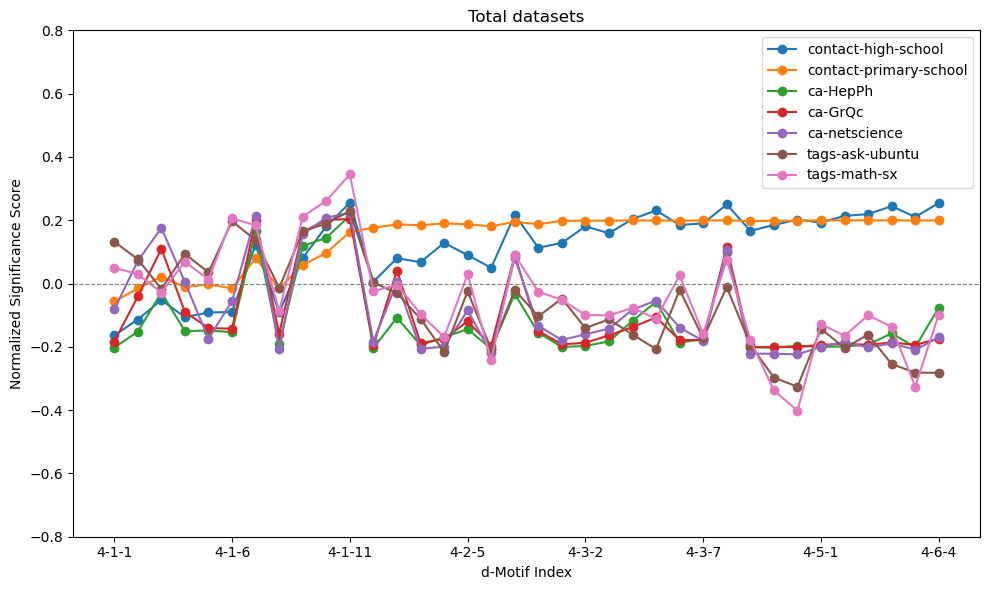

,0,1,2,3,4,5,6
0,1.000000,0.866819,0.210239,0.030709,-0.088946,-0.512574,-0.239629
1,0.866819,1.000000,-0.141962,-0.262881,-0.380855,-0.672666,-0.461280
2,0.210239,-0.141962,1.000000,0.937787,0.887975,0.570678,0.721219
3,0.030709,-0.262881,0.937787,1.000000,0.961005,0.658890,0.741412
4,-0.088946,-0.380855,0.887975,0.961005,1.000000,0.736871,0.800350
5,-0.512574,-0.672666,0.570678,0.658890,0.736871,1.000000,0.927125
6,-0.239629,-0.461280,0.721219,0.741412,0.800350,0.927125,1.000000


In [40]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the JSON file
with open('./extend_output/output.json') as f:
    real = json.load(f)

with open('./extend_output/random_output.json') as f:
    random = json.load(f)

# Extract the domain name
domain = 'Total'
sorted_keys = ['4-1-1', '4-1-2', '4-1-3', '4-1-4', '4-1-5', '4-1-6', '4-1-7', '4-1-8', '4-1-9', '4-1-10', '4-1-11',
               '4-2-1', '4-2-2', '4-2-3', '4-2-4', '4-2-5', '4-2-6', '4-2-7', '4-2-8',
               '4-3-1', '4-3-2', '4-3-3', '4-3-4', '4-3-5', '4-3-6', '4-3-7', '4-3-8',
               '4-4-1', '4-4-2', '4-4-3', 
               '4-5-1', '4-5-2', 
               '4-6-1', '4-6-2', '4-6-3', '4-6-4']
srp_data = []

# Define domain groups
domains = {
    'contact': [5, 6],
    'collaboration': [0, 1, 2],
    'tags' : [7, 8]
    #'socfb' : [10, 11, 12]
}
dataset_order= {}
for keys in domains:
    dataset_order[keys] = []
    

# Prepare for plotting
plt.figure(figsize=(10, 6))

index = 0
for group_name, indices in domains.items():
    for i in indices:
        real_data = real[i]
        random_data = random[i]

        dataset = real_data["dataset"]
        dataset_order[group_name].append(index)
        index += 1

        # Remove the dataset name from the data
        del real_data["dataset"]
        del random_data["dataset"]

        # Compute Delta_i for each subgraph
        epsilon = 4
        delta_i = {}
        for key in list(real_data.keys()):
            N_real_i = real_data[key]
            N_rand_i = random_data[key]
            delta_i[key] = (N_real_i - N_rand_i) / (N_real_i + N_rand_i + epsilon)

        # Normalize Delta_i to get SRP_i
        sum_delta_squared = sum([delta**2 for delta in delta_i.values()])
        srp_i = {key: delta / np.sqrt(sum_delta_squared) for key, delta in delta_i.items()}

        # Sort SRP_i by subgraph keys
        sorted_srp_i = [srp_i[key] for key in sorted_keys]
        srp_data.append(sorted_srp_i)

        # Plot the Subgraph Ratio Profile
        plt.plot(sorted_keys, sorted_srp_i, marker='o', label=f'{dataset}')

df = pd.DataFrame(srp_data).T
correlation_matrix = df.corr(method='pearson')

# Plot settings
plt.xlabel('d-Motif Index')
plt.ylabel('Normalized Significance Score')
plt.title(f'{domain} datasets')
plt.ylim(-0.8, 0.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()

num_labels_to_show = 8
step = len(sorted_keys) // (num_labels_to_show - 1)
visible_positions = list(range(0, len(sorted_keys), step))[:num_labels_to_show]
visible_labels = [sorted_keys[i] for i in visible_positions]
plt.xticks(visible_positions, visible_labels)


# Save the plot
filename = f'{domain}_extend.png'
plt.savefig(f'./figure/{filename}')

# Display the plot
plt.show()
correlation_matrix

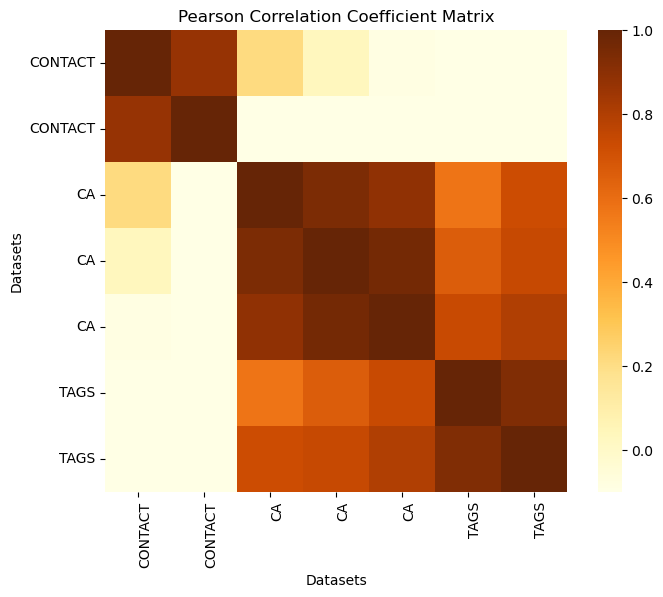

In [41]:
import seaborn as sns

labels = ['CONTACT', 'CONTACT', 'CA', 'CA', 'CA', 'TAGS', 'TAGS']
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='YlOrBr', cbar=True, square=True, vmin=-0.1, vmax=1)
plt.title('Pearson Correlation Coefficient Matrix')
plt.xlabel('Datasets')
plt.ylabel('Datasets')
# Add custom colored labels
ax = plt.gca()
ax.set_xticks(np.arange(len(labels)) + 0.5)
ax.set_yticks(np.arange(len(labels)) + 0.5)
ax.set_xticklabels(labels, rotation=90, ha='right', rotation_mode='anchor')
ax.set_yticklabels(labels, rotation=0)
plt.show()

#0.78 vs 0.70 #contact 제외한것도 설명

In [42]:
def calculate_average_correlations(correlation_matrix, domain_indices):
    intra_domain_corr = []
    inter_domain_corr = []
    item_intra_domain_corr = {}
    item_inter_domain_corr = {}
    
    for domain1, indices1 in domain_indices.items():
        for index in indices1:
            intra_corrs = []
            inter_corrs = []
            
            for other_domain, other_indices in domain_indices.items():
                if domain1 == other_domain:
                    # Intra-domain similarity
                    intra_corrs.extend(correlation_matrix.loc[index, other_indices].values)
                else:
                    # Inter-domain similarity
                    inter_corrs.extend(correlation_matrix.loc[index, other_indices].values)
            
            # Remove self-correlation
            intra_corrs = [corr for corr in intra_corrs if corr != 1.0]
            
            if intra_corrs:
                item_intra_domain_corr[index] = np.mean(intra_corrs)
                intra_domain_corr.append(item_intra_domain_corr[index])
            else:
                item_intra_domain_corr[index] = np.nan
            
            if inter_corrs:
                item_inter_domain_corr[index] = np.mean(inter_corrs)
                inter_domain_corr.append(item_inter_domain_corr[index])
            else:
                item_inter_domain_corr[index] = np.nan
    
    average_intra_domain_corr = np.mean(intra_domain_corr) if intra_domain_corr else np.nan
    average_inter_domain_corr = np.mean(inter_domain_corr) if inter_domain_corr else np.nan
    
    return average_intra_domain_corr, average_inter_domain_corr, item_intra_domain_corr, item_inter_domain_corr

average_intra_domain_corr, average_inter_domain_corr, item_intra_corr, item_inter_corr = calculate_average_correlations(correlation_matrix, dataset_order)

print(f'Average correlation within the same domain: {average_intra_domain_corr:.4f}')
print(f'Average correlation between different domains: {average_inter_domain_corr:.4f}')

print("\nIntra-domain correlations for each item:")
for item, corr in item_intra_corr.items():
    print(f'{item}: {corr:.4f}')

print("\nInter-domain correlations for each item:")
for item, corr in item_inter_corr.items():
    print(f'{item}: {corr:.4f}')

Average correlation within the same domain: 0.9107
Average correlation between different domains: 0.1234

Intra-domain correlations for each item:
0: 0.8668
1: 0.8668
2: 0.9129
3: 0.9494
4: 0.9245
5: 0.9271
6: 0.9271

Inter-domain correlations for each item:
0: -0.1200
1: -0.3839
2: 0.3400
3: 0.2920
4: 0.2669
5: 0.1562
6: 0.3124


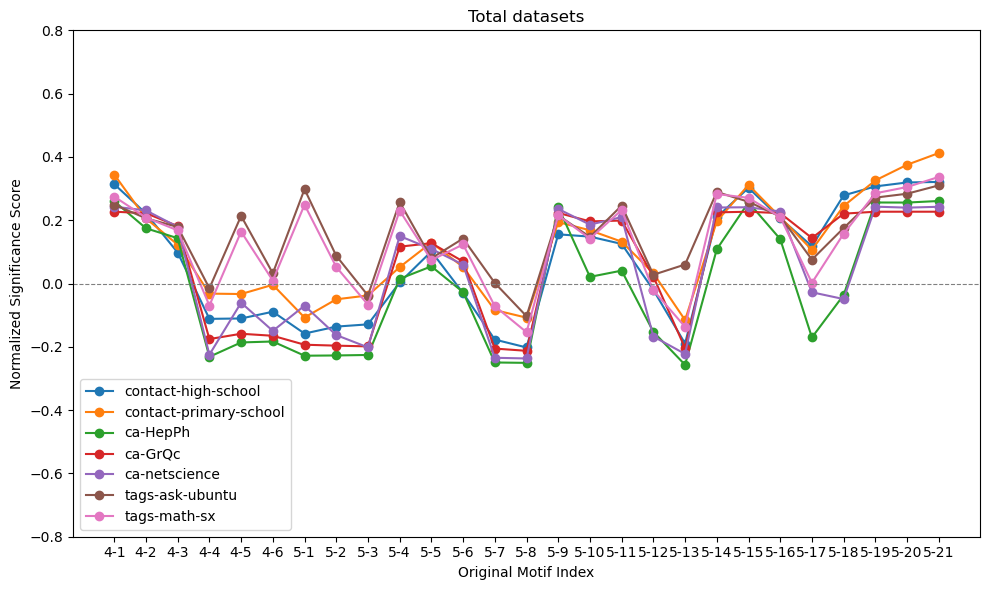

,0,1,2,3,4,5,6
0,1.000000,0.983325,0.910417,0.940353,0.862236,0.692013,0.775925
1,0.983325,1.000000,0.925090,0.897986,0.846917,0.679634,0.775037
2,0.910417,0.925090,1.000000,0.896293,0.944283,0.738034,0.824771
3,0.940353,0.897986,0.896293,1.000000,0.909970,0.680629,0.752171
4,0.862236,0.846917,0.944283,0.909970,1.000000,0.823279,0.884026
5,0.692013,0.679634,0.738034,0.680629,0.823279,1.000000,0.966136
6,0.775925,0.775037,0.824771,0.752171,0.884026,0.966136,1.000000


In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the JSON file
with open('./original_output/output.json') as f:
    real = json.load(f)

with open('./original_output/random_output.json') as f:
    random = json.load(f)

# Extract the domain name
domain = 'Total'
sorted_keys = ['4-1', '4-2', '4-3', '4-4', '4-5', '4-6']

sorted_keys = ['5-1', '5-2', '5-3', '5-4', '5-5', '5-6', '5-7', '5-8', '5-9', '5-10', '5-11', '5-12', '5-13', '5-14', '5-15', '5-16', '5-17', '5-18', '5-19', '5-20', '5-21']

sorted_keys = ['4-1', '4-2', '4-3', '4-4', '4-5', '4-6', '5-1', '5-2', '5-3', '5-4', '5-5', '5-6', '5-7', '5-8', '5-9', '5-10', '5-11', '5-12', '5-13', '5-14', '5-15', '5-16', '5-17', '5-18', '5-19', '5-20', '5-21']
srp_data = []

# Define domain groups
domains = {
    'contact': [5, 6],
    'collaboration': [0, 1, 2],
    'tags' : [7, 8]
    #'socfb' : [10, 11, 12]
}
dataset_order= {}
for keys in domains:
    dataset_order[keys] = []
    

# Prepare for plotting
plt.figure(figsize=(10, 6))

index = 0
for group_name, indices in domains.items():
    for i in indices:
        real_data = real[i]
        random_data = random[i]

        dataset = real_data["dataset"]
        dataset_order[group_name].append(index)
        index += 1

        # Remove the dataset name from the data
        del real_data["dataset"]
        del random_data["dataset"]

        # Compute Delta_i for each subgraph
        epsilon = 4
        delta_i = {}
        for key in list(real_data.keys()):
            N_real_i = real_data[key]
            N_rand_i = random_data[key]
            delta_i[key] = (N_real_i - N_rand_i) / (N_real_i + N_rand_i + epsilon)

        # Normalize Delta_i to get SRP_i
        sum_delta_squared = sum([delta**2 for delta in delta_i.values()])
        srp_i = {key: delta / np.sqrt(sum_delta_squared) for key, delta in delta_i.items()}

        # Sort SRP_i by subgraph keys
        sorted_srp_i = [srp_i[key] for key in sorted_keys]
        srp_data.append(sorted_srp_i)

        # Plot the Subgraph Ratio Profile
        plt.plot(sorted_keys, sorted_srp_i, marker='o', label=f'{dataset}')

df = pd.DataFrame(srp_data).T
correlation_matrix = df.corr(method='pearson')

# Plot settings
plt.xlabel('Original Motif Index')
plt.ylabel('Normalized Significance Score')
plt.title(f'{domain} datasets')
plt.ylim(-0.8, 0.8)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend()
plt.tight_layout()

# Save the plot
filename = f'{domain}_original.png'
plt.savefig(f'./figure/{filename}')

# Display the plot
plt.show()
correlation_matrix


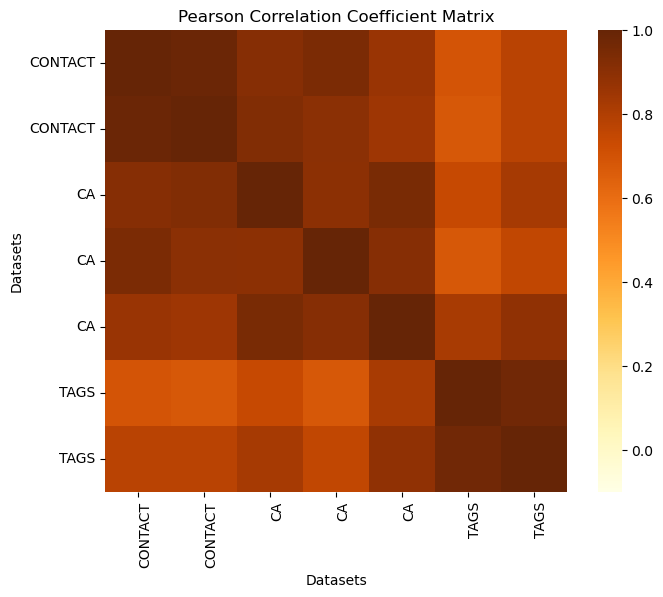

In [20]:
import seaborn as sns

labels = ['CONTACT', 'CONTACT', 'CA', 'CA', 'CA', 'TAGS', 'TAGS']
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=False, fmt=".2f", cmap='YlOrBr', cbar=True, square=True, vmin=-0.1, vmax=1)
plt.title('Pearson Correlation Coefficient Matrix')
plt.xlabel('Datasets')
plt.ylabel('Datasets')
# Add custom colored labels
ax = plt.gca()
ax.set_xticks(np.arange(len(labels)) + 0.5)
ax.set_yticks(np.arange(len(labels)) + 0.5)
ax.set_xticklabels(labels, rotation=90, ha='right', rotation_mode='anchor')
ax.set_yticklabels(labels, rotation=0)
plt.show()

In [21]:
def calculate_average_correlations(correlation_matrix, domain_indices):
    intra_domain_corr = []
    inter_domain_corr = []
    item_intra_domain_corr = {}
    item_inter_domain_corr = {}
    
    for domain1, indices1 in domain_indices.items():
        for index in indices1:
            intra_corrs = []
            inter_corrs = []
            
            for other_domain, other_indices in domain_indices.items():
                if domain1 == other_domain:
                    # Intra-domain similarity
                    intra_corrs.extend(correlation_matrix.loc[index, other_indices].values)
                else:
                    # Inter-domain similarity
                    inter_corrs.extend(correlation_matrix.loc[index, other_indices].values)
            
            # Remove self-correlation
            intra_corrs = [corr for corr in intra_corrs if corr != 1.0]
            
            if intra_corrs:
                item_intra_domain_corr[index] = np.mean(intra_corrs)
                intra_domain_corr.append(item_intra_domain_corr[index])
            else:
                item_intra_domain_corr[index] = np.nan
            
            if inter_corrs:
                item_inter_domain_corr[index] = np.mean(inter_corrs)
                inter_domain_corr.append(item_inter_domain_corr[index])
            else:
                item_inter_domain_corr[index] = np.nan
    
    average_intra_domain_corr = np.mean(intra_domain_corr) if intra_domain_corr else np.nan
    average_inter_domain_corr = np.mean(inter_domain_corr) if inter_domain_corr else np.nan
    
    return average_intra_domain_corr, average_inter_domain_corr, item_intra_domain_corr, item_inter_domain_corr

average_intra_domain_corr, average_inter_domain_corr, item_intra_corr, item_inter_corr = calculate_average_correlations(correlation_matrix, dataset_order)

print(f'Average correlation within the same domain: {average_intra_domain_corr:.4f}')
print(f'Average correlation between different domains: {average_inter_domain_corr:.4f}')

print("\nIntra-domain correlations for each item:")
for item, corr in item_intra_corr.items():
    print(f'{item}: {corr:.4f}')

print("\nInter-domain correlations for each item:")
for item, corr in item_inter_corr.items():
    print(f'{item}: {corr:.4f}')

Average correlation within the same domain: 0.9499
Average correlation between different domains: 0.8154

Intra-domain correlations for each item:
0: 0.9833
1: 0.9833
2: 0.9203
3: 0.9031
4: 0.9271
5: 0.9661
6: 0.9661

Inter-domain correlations for each item:
0: 0.8362
1: 0.8249
2: 0.8496
3: 0.8178
4: 0.8541
5: 0.7227
6: 0.8024


4 + 5 : 0.96 / 0.85 Pearson : 0.93 / 0.83

4 : Spearman : 0.93 / 0.81  Pearson : 0.97 / 0.86

5 : Speraman : 0.95 / 0.85  Pearson : 0.93 / 0.82